In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter

# === Load .npy files ===
X_seq = np.load("X_seq.npy")  # shape: (N, 100, 1024)
y_seq = np.load("y_seq.npy")  # shape: (N,)

# === Equalize classes ===
#class_counts = Counter(y_seq)
#min_count = min(class_counts.values())  # smallest class count (e.g. 40)

# Collect balanced indices
#selected_indices = []
#for cls in range(57):  # assuming classes are 0 to 56
 #   cls_indices = np.where(y_seq == cls)[0]
  #  chosen = np.random.choice(cls_indices, min_count, replace=False)
   # selected_indices.extend(chosen)

# Final balanced arrays
# X_balanced = X_seq[selected_indices]
# y_balanced = y_seq[selected_indices]

X_balanced = X_seq
y_balanced = y_seq

# === Split into train/test (stratified) ===
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# === Further split train into train/val (stratified) ===
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_train_np, y_train_np, test_size=0.1, stratify=y_train_np, random_state=42
)

# === Convert to PyTorch tensors ===
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)
X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.long)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.long)

# === Wrap in TensorDataset ===
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# === DataLoaders ===
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print("✅ Balanced DataLoaders ready:")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


✅ Balanced DataLoaders ready:
Train: 7726 | Val: 859 | Test: 2147


In [2]:
from sklearn.utils.class_weight import compute_class_weight
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = np.unique(y_balanced)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_balanced)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [3]:
# === Check class presence ===
def count_unique_classes(dataset, name):
    labels = torch.tensor([label.item() for _, label in dataset])
    unique_classes = torch.unique(labels)
    print(f"{name} has {len(unique_classes)} unique classes: {sorted(unique_classes.tolist())}")

count_unique_classes(train_dataset, "Train")
count_unique_classes(val_dataset, "Validation")
count_unique_classes(test_dataset, "Test")

from collections import Counter

def print_class_distribution(dataset, name):
    labels = [label.item() for _, label in dataset]
    class_counts = Counter(labels)
    print(f"\n{name} class distribution:")
    for cls in sorted(class_counts):
        print(f"Class {cls}: {class_counts[cls]} samples")

print_class_distribution(train_dataset, "Train")
print_class_distribution(val_dataset, "Validation")
print_class_distribution(test_dataset, "Test")



Train has 57 unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
Validation has 57 unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
Test has 57 unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]

Train class distribution:
Class 0: 720 samples
Class 1: 29 samples
Class 2: 29 samples
Class 3: 29 samples
Class 4: 29 samples
Class 5: 337 samples
Class 6: 29 samples
Class 7: 29 samples
Class 8: 720 samples
Class 9: 29 samples
Class 10: 29 samples
C

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YAMNet1DCNN_Improved(nn.Module):
    def __init__(self, num_classes=57):
        super().__init__()
        self.conv1 = nn.Conv1d(1024, 512, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(512)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(512, 256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.7)  # Slightly higher for better regularization
        self.fc = nn.Linear(128, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, 100, 1024) → (B, 1024, 100)
        x = self.pool1(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool2(F.gelu(self.bn2(self.conv2(x))))
        x = F.gelu(self.bn3(self.conv3(x)))
        x = self.global_pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)


In [6]:
class YAMNetMLP(nn.Module):
    def __init__(self, num_classes=57):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),                           # (B, 100, 1024) → (B, 102400)
            nn.Linear(100 * 1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [7]:
class YAMNetRNN(nn.Module):
    def __init__(self, hidden_size=512, num_layers=2, num_classes=57, dropout=0.3):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=1024,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity='relu',        # Better gradient flow than tanh
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):  # x: (B, 100, 1024)
        out, _ = self.rnn(x)
        last = out[:, -1, :]  # Get output of last time step
        return self.fc(last)


In [8]:
class YAMNetLSTM(nn.Module):
    def __init__(self, hidden_size=128, num_layers=1, num_classes=57, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1024, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):  # x: (B, 100, 1024)
        out, _ = self.lstm(x)            # out: (B, 100, hidden)
        last = out[:, -1, :]             # (B, hidden)
        return self.fc(last)

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def train_and_evaluate(model, model_name, train_loader, val_loader, test_loader,
                       class_weights_tensor=None, epochs=100, patience=30, save_threshold=90):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, min_lr=1e-6)

    best_val_acc = 0
    no_improve_epochs = 0
    saved_model_name = None

    # Metrics
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (preds.argmax(1) == yb).sum().item()

        train_acc = 100. * correct / len(train_loader.dataset)
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_correct += (preds.argmax(1) == yb).sum().item()
                val_total += yb.size(0)
        val_acc = 100. * val_correct / val_total
        val_accuracies.append(val_acc)

        scheduler.step(val_acc)

        print(f"[{model_name}] Epoch {epoch}: Loss={total_loss:.2f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

        # Save best
        if val_acc >= save_threshold:
            val_str = f"{val_acc:.2f}".replace('.', '_')
            saved_model_name = f"{model_name}_{val_str}_Epoch{epoch}.pt"
            torch.save(model.state_dict(), saved_model_name)
            print(f"✅ Saved model: {saved_model_name} (Val Acc: {val_acc:.2f}%)")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print("⛔ Early stopping triggered.")
                break

    # Evaluate
    model.eval()
    all_preds = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            preds = model(xb)
            all_preds.append(preds)

    all_preds = torch.cat(all_preds).argmax(1).cpu().numpy()
    y_test_np = test_loader.dataset.tensors[1].cpu().numpy()
    test_acc = accuracy_score(y_test_np, all_preds)
    print(f"\n✅ Final Test Accuracy for {model_name}: {test_acc * 100:.2f}%")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Acc")
    plt.plot(val_accuracies, label="Val Acc")
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [28]:
import os
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

def find_best_model_name(model_type_prefix, model_class, test_loader, metric='test_acc'):
    """
    Finds the best model filename (e.g., 'CNN_92_10_Epoch55.pt') by specified metric.

    Args:
        model_type_prefix (str): e.g., 'CNN', 'RNN', etc.
        model_class (nn.Module): Model class to instantiate and load.
        test_loader (DataLoader): Test data.
        metric (str): 'test_acc' or 'avg_class_acc'.

    Returns:
        str: Best model filename.
    """
    model_files = [f for f in os.listdir() if f.startswith(model_type_prefix) and f.endswith('.pt')]
    if not model_files:
        raise FileNotFoundError(f"No model files found for prefix: {model_type_prefix}")

    results = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for file in model_files:
        model = model_class().to(device)
        model.load_state_dict(torch.load(file, map_location=device))
        model.eval()

        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        test_acc = accuracy_score(all_labels, all_preds) * 100
        cm = confusion_matrix(all_labels, all_preds)
        per_class_acc = np.diag(cm) / np.maximum(cm.sum(axis=1), 1)
        avg_class_acc = np.mean(per_class_acc) * 100

        results.append((file, test_acc, avg_class_acc))

    if metric == 'test_acc':
        best_model = max(results, key=lambda x: x[1])
    elif metric == 'avg_class_acc':
        best_model = max(results, key=lambda x: x[2])
    else:
        raise ValueError("metric must be 'test_acc' or 'avg_class_acc'")

    return best_model[0]


In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def evaluate_model(
    model_name,
    model_class,
    model_path,
    test_loader,
    show_confusion_matrix=True,
    show_classification_report=True,
    show_per_class_accuracy=True,
    show_avg_per_class=True
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Overall Accuracy for {model_name}: {acc * 100:.2f}%")

    # === Classification Report ===
    if show_classification_report:
        print("\n📄 Classification Report:")
        print(classification_report(all_labels, all_preds, zero_division=0))

    # === Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    if show_confusion_matrix:
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix — {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    # === Per-Class Accuracy ===
    if show_per_class_accuracy:
        class_counts = cm.sum(axis=1)
        correct_counts = np.diag(cm)
        class_accuracy = correct_counts / np.maximum(class_counts, 1)

        plt.figure(figsize=(14, 6))
        plt.bar(range(len(class_accuracy)), class_accuracy)
        plt.xticks(ticks=range(len(class_accuracy)), labels=range(len(class_accuracy)), rotation=90)
        plt.ylim(0, 1.05)
        plt.ylabel("Accuracy")
        plt.title(f"Per-Class Accuracy — {model_name}")
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

        print("\n📊 Per-Class Accuracy:")
        for i, acc in enumerate(class_accuracy):
            print(f"Class {i:<2}: {acc * 100:.2f}%")

        if show_avg_per_class:
            avg_class_acc = np.mean(class_accuracy)
            print(f"\n📈 Average Per-Class Accuracy: {avg_class_acc * 100:.2f}%")


[CNN] Epoch 0: Loss=942.22, Train Acc=11.31%, Val Acc=43.19%
[CNN] Epoch 1: Loss=713.19, Train Acc=31.53%, Val Acc=52.97%
[CNN] Epoch 2: Loss=545.02, Train Acc=47.51%, Val Acc=65.08%
[CNN] Epoch 3: Loss=460.82, Train Acc=54.84%, Val Acc=66.94%
[CNN] Epoch 4: Loss=392.39, Train Acc=60.04%, Val Acc=65.54%
[CNN] Epoch 5: Loss=352.60, Train Acc=62.94%, Val Acc=74.16%
[CNN] Epoch 6: Loss=313.59, Train Acc=66.57%, Val Acc=76.02%
[CNN] Epoch 7: Loss=288.65, Train Acc=69.93%, Val Acc=77.42%
[CNN] Epoch 8: Loss=261.89, Train Acc=73.17%, Val Acc=78.46%
[CNN] Epoch 9: Loss=246.77, Train Acc=73.66%, Val Acc=79.05%
[CNN] Epoch 10: Loss=224.54, Train Acc=76.82%, Val Acc=79.86%
[CNN] Epoch 11: Loss=201.03, Train Acc=77.52%, Val Acc=79.51%
[CNN] Epoch 12: Loss=207.92, Train Acc=78.70%, Val Acc=79.86%
[CNN] Epoch 13: Loss=192.78, Train Acc=79.25%, Val Acc=81.96%
[CNN] Epoch 14: Loss=168.15, Train Acc=80.79%, Val Acc=81.72%
[CNN] Epoch 15: Loss=158.11, Train Acc=81.41%, Val Acc=82.65%
[CNN] Epoch 16: Lo

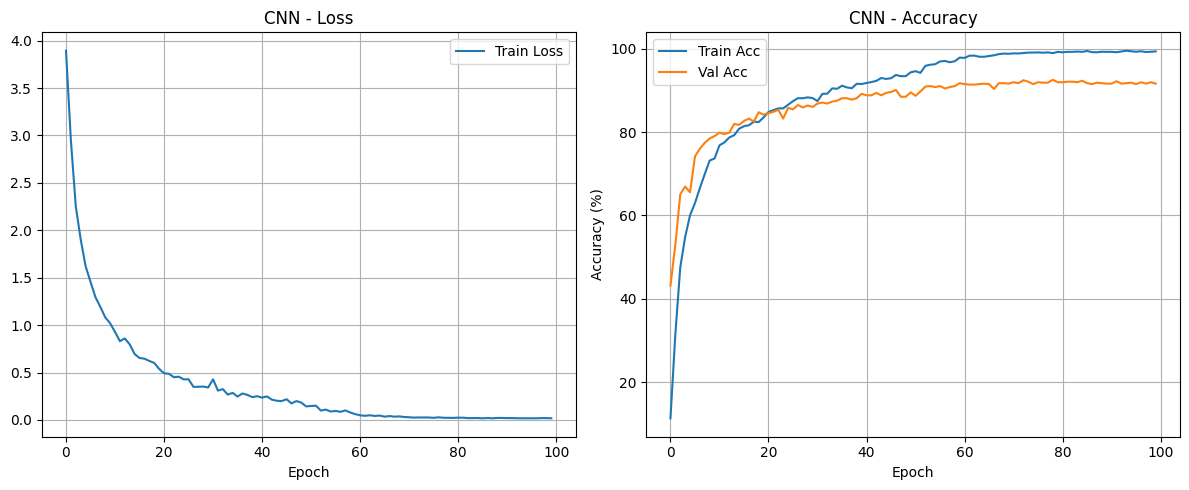

In [14]:
train_and_evaluate(YAMNet1DCNN_Improved(), "CNN", train_loader, val_loader, test_loader, class_weights_tensor,epochs = 100, patience=50, save_threshold=90)

Best CNN model: CNN_91_97_Epoch79.pt

✅ Overall Accuracy for CNN: 93.25%

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       200
           1       0.86      0.75      0.80         8
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         8
           4       0.89      1.00      0.94         8
           5       0.93      0.93      0.93        94
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       0.92      0.93      0.92       200
           9       1.00      0.88      0.93         8
          10       1.00      1.00      1.00         8
          11       1.00      0.88      0.93         8
          12       1.00      0.88      0.93         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00   

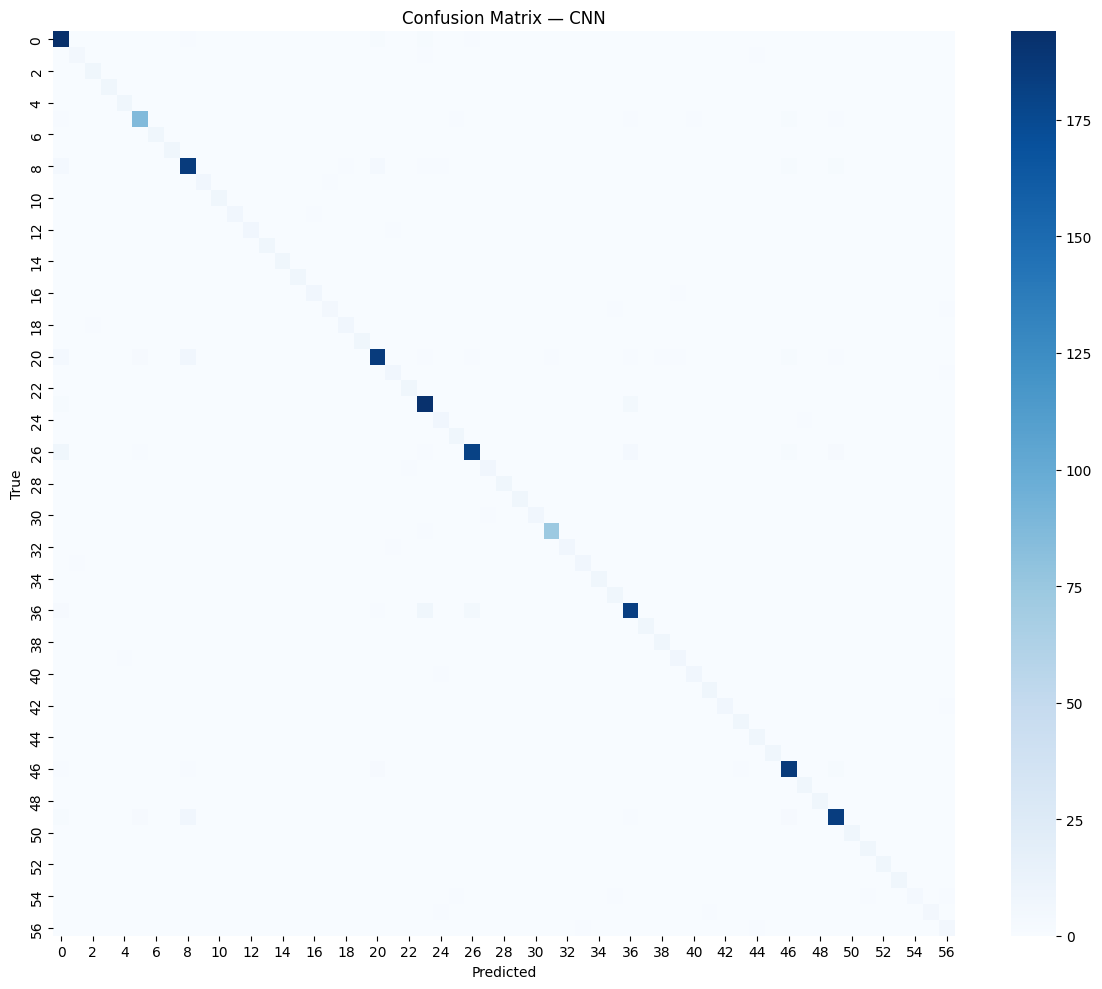

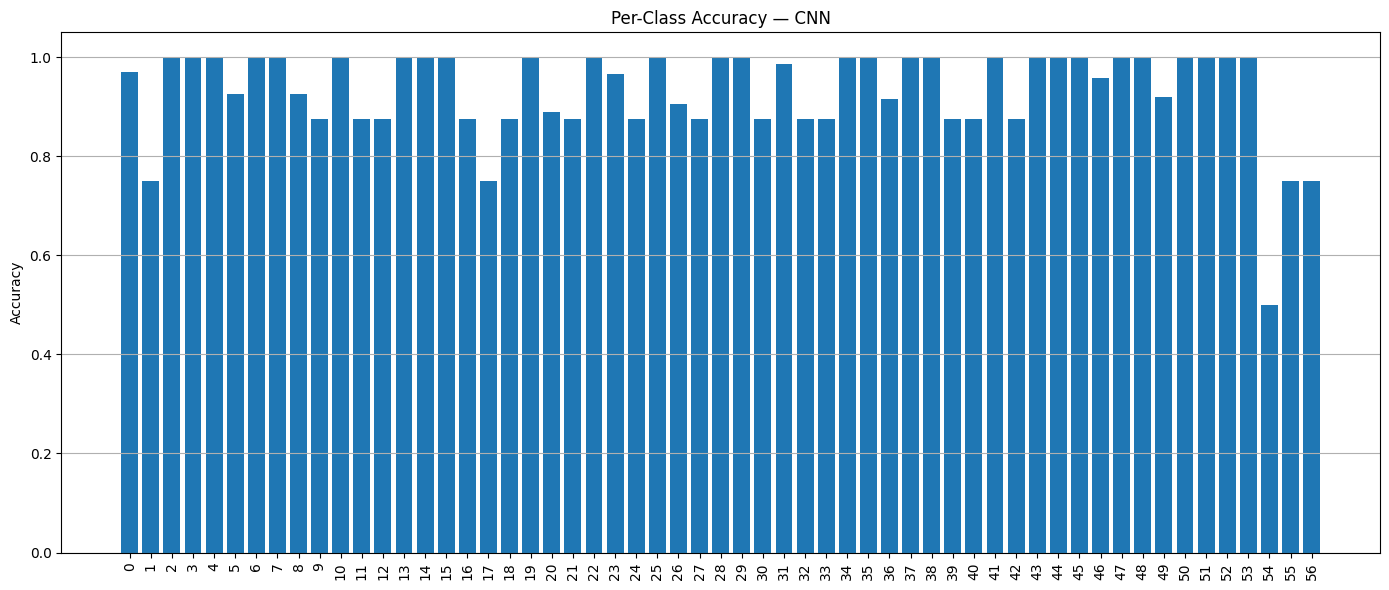


📊 Per-Class Accuracy:
Class 0 : 97.00%
Class 1 : 75.00%
Class 2 : 100.00%
Class 3 : 100.00%
Class 4 : 100.00%
Class 5 : 92.55%
Class 6 : 100.00%
Class 7 : 100.00%
Class 8 : 92.50%
Class 9 : 87.50%
Class 10: 100.00%
Class 11: 87.50%
Class 12: 87.50%
Class 13: 100.00%
Class 14: 100.00%
Class 15: 100.00%
Class 16: 87.50%
Class 17: 75.00%
Class 18: 87.50%
Class 19: 100.00%
Class 20: 88.94%
Class 21: 87.50%
Class 22: 100.00%
Class 23: 96.50%
Class 24: 87.50%
Class 25: 100.00%
Class 26: 90.50%
Class 27: 87.50%
Class 28: 100.00%
Class 29: 100.00%
Class 30: 87.50%
Class 31: 98.67%
Class 32: 87.50%
Class 33: 87.50%
Class 34: 100.00%
Class 35: 100.00%
Class 36: 91.50%
Class 37: 100.00%
Class 38: 100.00%
Class 39: 87.50%
Class 40: 87.50%
Class 41: 100.00%
Class 42: 87.50%
Class 43: 100.00%
Class 44: 100.00%
Class 45: 100.00%
Class 46: 95.88%
Class 47: 100.00%
Class 48: 100.00%
Class 49: 92.00%
Class 50: 100.00%
Class 51: 100.00%
Class 52: 100.00%
Class 53: 100.00%
Class 54: 50.00%
Class 55: 75.0

In [39]:
best_model_cnn = find_best_model_name(
    model_type_prefix="CNN",
    model_class=YAMNet1DCNN_Improved,
    test_loader=test_loader,
    metric='test_acc'
)
print(f"Best CNN model: {best_model_cnn}")

evaluate_model(
    model_name="CNN",
    model_class=YAMNet1DCNN_Improved,
    model_path=best_model_cnn,
    test_loader=test_loader,
    show_confusion_matrix=True,
    show_classification_report=True,
    show_per_class_accuracy=True,
    show_avg_per_class=True
)

In [ ]:
train_and_evaluate(YAMNetMLP(), "MLP", train_loader, val_loader, test_loader, class_weights_tensor, epochs=100, patience=50, save_threshold=87.5)

Best MLP model: MLP_88_36_Epoch67.pt

✅ Overall Accuracy for MLP: 88.45%

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       200
           1       0.71      0.62      0.67         8
           2       0.75      0.75      0.75         8
           3       1.00      0.75      0.86         8
           4       0.50      0.38      0.43         8
           5       0.92      0.89      0.91        94
           6       0.88      0.88      0.88         8
           7       0.88      0.88      0.88         8
           8       0.89      0.91      0.90       200
           9       0.88      0.88      0.88         8
          10       1.00      1.00      1.00         8
          11       1.00      0.75      0.86         8
          12       1.00      0.88      0.93         8
          13       1.00      1.00      1.00         8
          14       0.56      0.62      0.59         8
          15       0.71      0.62   

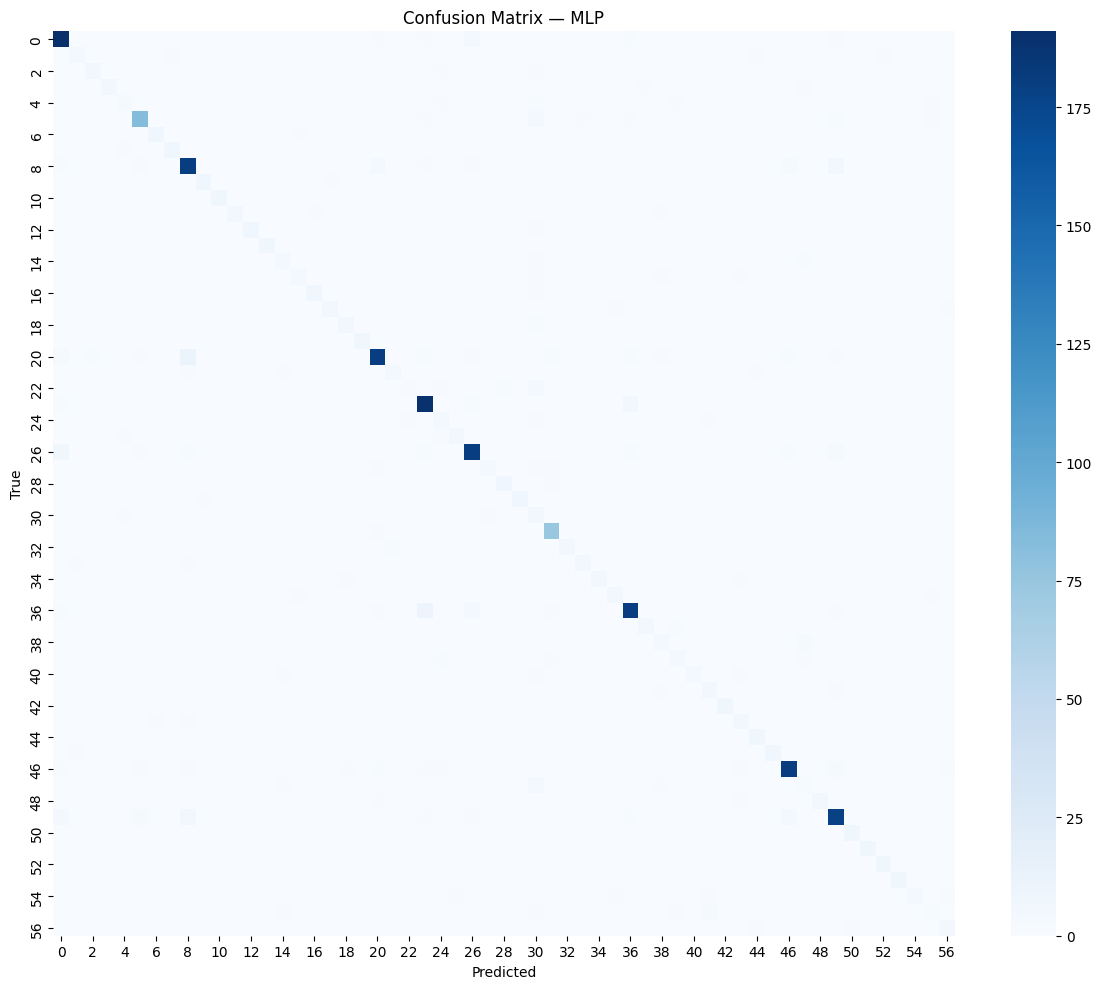

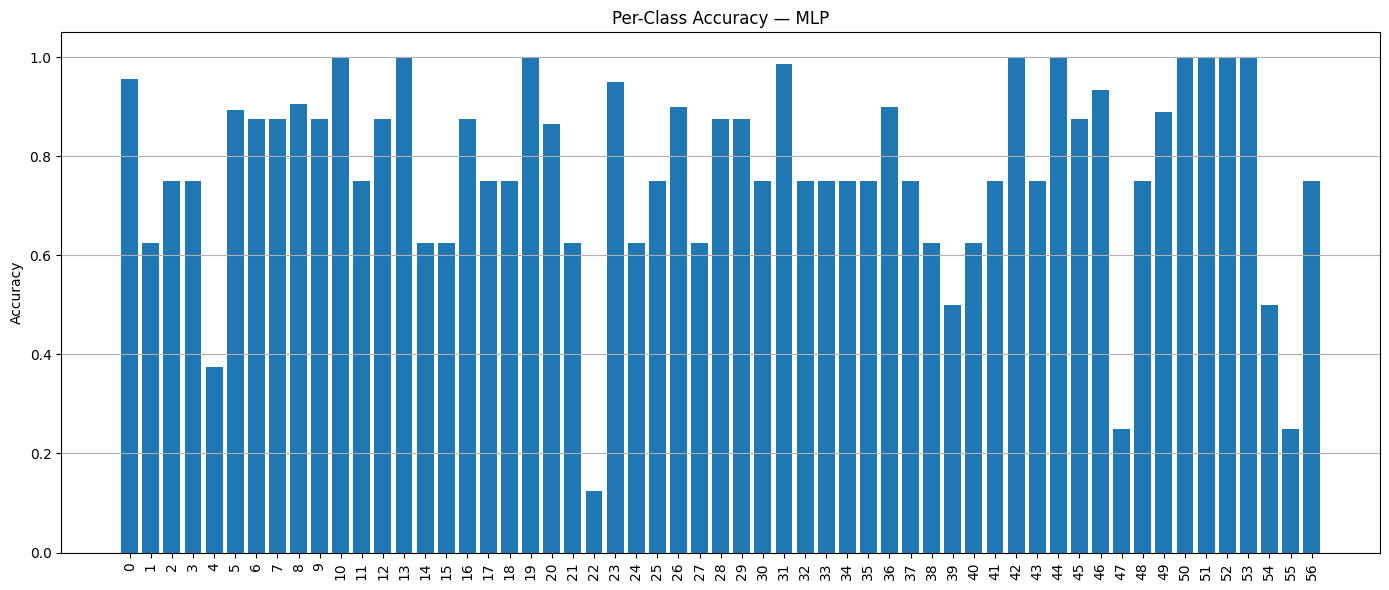


📊 Per-Class Accuracy:
Class 0 : 95.50%
Class 1 : 62.50%
Class 2 : 75.00%
Class 3 : 75.00%
Class 4 : 37.50%
Class 5 : 89.36%
Class 6 : 87.50%
Class 7 : 87.50%
Class 8 : 90.50%
Class 9 : 87.50%
Class 10: 100.00%
Class 11: 75.00%
Class 12: 87.50%
Class 13: 100.00%
Class 14: 62.50%
Class 15: 62.50%
Class 16: 87.50%
Class 17: 75.00%
Class 18: 75.00%
Class 19: 100.00%
Class 20: 86.54%
Class 21: 62.50%
Class 22: 12.50%
Class 23: 95.00%
Class 24: 62.50%
Class 25: 75.00%
Class 26: 90.00%
Class 27: 62.50%
Class 28: 87.50%
Class 29: 87.50%
Class 30: 75.00%
Class 31: 98.67%
Class 32: 75.00%
Class 33: 75.00%
Class 34: 75.00%
Class 35: 75.00%
Class 36: 90.00%
Class 37: 75.00%
Class 38: 62.50%
Class 39: 50.00%
Class 40: 62.50%
Class 41: 75.00%
Class 42: 100.00%
Class 43: 75.00%
Class 44: 100.00%
Class 45: 87.50%
Class 46: 93.30%
Class 47: 25.00%
Class 48: 75.00%
Class 49: 89.00%
Class 50: 100.00%
Class 51: 100.00%
Class 52: 100.00%
Class 53: 100.00%
Class 54: 50.00%
Class 55: 25.00%
Class 56: 75.00%

In [ ]:
best_model_mlp = find_best_model_name(
    model_type_prefix="MLP",
    model_class=YAMNetMLP,
    test_loader=test_loader,
    metric='avg_class_acc'
)
print(f"Best MLP model: {best_model_cnn}")

evaluate_model(
    model_name="MLP",
    model_class=YAMNetMLP,
    model_path=best_model_cnn,
    test_loader=test_loader,
    show_confusion_matrix=True,
    show_classification_report=True,
    show_per_class_accuracy=True,
    show_avg_per_class=True
)

In [40]:
train_and_evaluate(YAMNetRNN(), "RNN", train_loader, val_loader, test_loader, class_weights_tensor, epochs=100, patience=50, save_threshold=90)

[RNN] Epoch 0: Loss=979.44, Train Acc=6.81%, Val Acc=9.31%
[RNN] Epoch 1: Loss=978.77, Train Acc=7.93%, Val Acc=9.31%


KeyboardInterrupt: 

In [41]:
train_and_evaluate(YAMNetLSTM(), "LSTM", train_loader, val_loader, test_loader, class_weights_tensor, epochs=100, patience=50, save_threshold=90)

[LSTM] Epoch 0: Loss=979.59, Train Acc=2.52%, Val Acc=4.42%
[LSTM] Epoch 1: Loss=979.22, Train Acc=5.99%, Val Acc=9.78%
[LSTM] Epoch 2: Loss=978.96, Train Acc=9.51%, Val Acc=9.78%
[LSTM] Epoch 3: Loss=978.58, Train Acc=9.20%, Val Acc=9.78%
[LSTM] Epoch 4: Loss=978.81, Train Acc=9.24%, Val Acc=9.78%
[LSTM] Epoch 5: Loss=978.43, Train Acc=8.72%, Val Acc=9.78%
[LSTM] Epoch 6: Loss=978.71, Train Acc=8.39%, Val Acc=9.78%
[LSTM] Epoch 7: Loss=978.22, Train Acc=9.68%, Val Acc=9.78%
[LSTM] Epoch 8: Loss=978.30, Train Acc=9.10%, Val Acc=9.78%
[LSTM] Epoch 9: Loss=978.46, Train Acc=9.35%, Val Acc=9.31%
[LSTM] Epoch 10: Loss=978.45, Train Acc=9.60%, Val Acc=9.08%
[LSTM] Epoch 11: Loss=977.95, Train Acc=7.79%, Val Acc=9.31%
[LSTM] Epoch 12: Loss=978.03, Train Acc=9.28%, Val Acc=9.31%
[LSTM] Epoch 13: Loss=978.11, Train Acc=9.32%, Val Acc=9.31%
[LSTM] Epoch 14: Loss=978.19, Train Acc=9.28%, Val Acc=9.31%
[LSTM] Epoch 15: Loss=978.04, Train Acc=8.94%, Val Acc=9.31%


KeyboardInterrupt: 